In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.transforms as mtransforms


from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)


In [9]:
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2


In [10]:
# load  dataset
df = pd.read_csv('/home/francovm/Projects/SSE/data/processed/GISB.csv', sep='\t', encoding='utf-8')

df = df.drop(df.columns[[1, 3, 5]], axis=1)
df.head()

,x,n,u,Events
0,-16.61,-159.10,25.17,1.0
1,-14.99,-158.86,22.46,1.0
2,-15.46,-160.53,22.91,1.0
3,-14.62,-159.06,20.10,1.0
4,-14.13,-160.20,16.44,1.0


[]

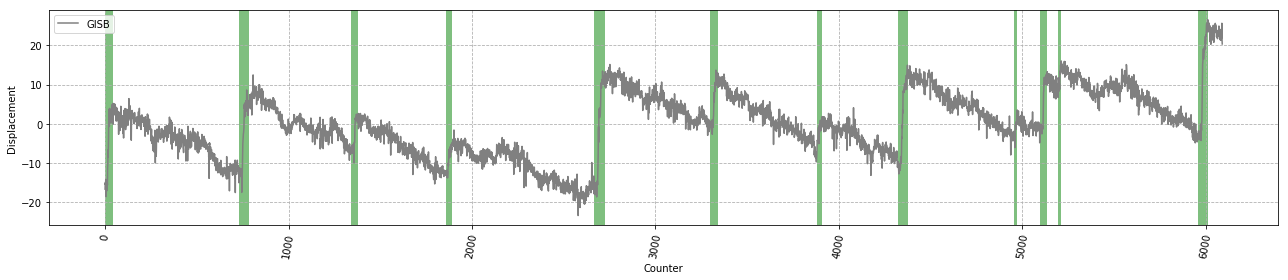

In [11]:
fig, ax = plt.subplots()

plt.plot(df['x'],'-', color='gray',label="GISB")
# plt.plot(dataset_test['Events'],'-', color='gray',label="GISB")
    # plt.plot_date(visitors2['Date'],visitors2['Visitors'].rolling(5).mean(),'g-',label="Unique Visitors- mean")

    # plt.axvline(x='2018-07-31', color='r', linestyle='--',label="CWB turn off")
plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
# if (dataset_test['Events'] == 0.5): plt.axhline()
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df['Events'])), min(df['Events']), max(df['Events']), where=(df['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

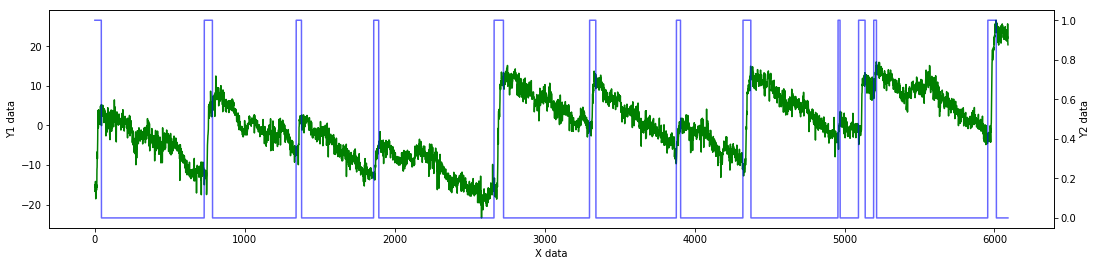

In [12]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df.index, df['x'], 'g-')
ax2.plot(df.index, df['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

In [13]:
input_X = df.loc[:, df.columns != 'Events'].values  # converts the df to a numpy array
input_y = df['Events'].values

n_features = input_X.shape[1]  # number of features

print(input_X.shape,input_y.shape)

(6091, 3) (6091,)


In [14]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return np.array(X), np.array(y)

## 20 Days Window Time

In [15]:
# Temporalize the data
lookback = 20
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [16]:
print(X_gisb.shape,y_gisb.shape)

(6070, 20, 3) (6070,)


In [17]:
# plt.plot(y_gisb) # plotting by columns
# plt.plot(df['x'],'-', color='gray',label="GISB")
# plt.show()

In [18]:
# load model
model = load_model("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_20days.h5")
# summarize model.
model.summary()


W1022 06:54:24.817116 140656359008064 deprecation_wrapper.py:119] From /home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1022 06:54:24.820637 140656359008064 deprecation_wrapper.py:119] From /home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 06:54:24.828720 140656359008064 deprecation_wrapper.py:119] From /home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1022 06:54:25.055708 140656359008064 deprecation_wrapper.py:119] From /home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_defa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [19]:
y_pred = model.predict_classes(X_gisb)

In [20]:
df_xarray = df['x'].iloc[20:]


In [21]:
df_result = pd.DataFrame(data=[df_xarray.values,y_pred]).T
df_result.columns = ['x','Events']

In [22]:
df_result.head()

,x,Events
0,1.3,[1]
1,-0.12,[1]
2,3.77,[1]
3,-0.64,[1]
4,-0.17,[1]


[]

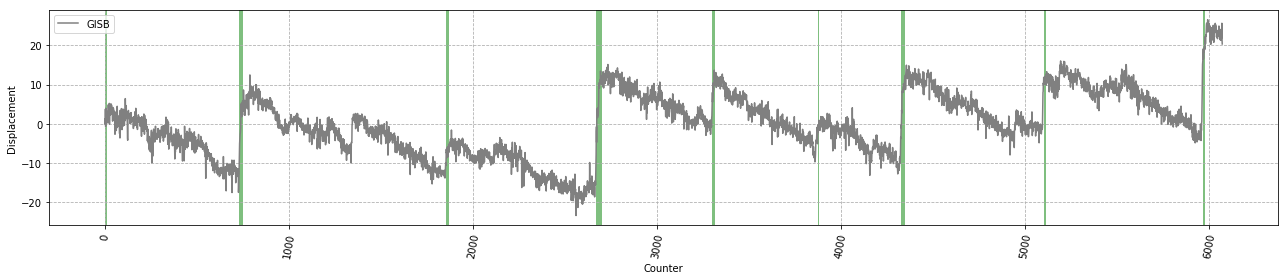

In [23]:
fig, ax = plt.subplots()

plt.plot(df_result['x'],'-', color='gray',label="GISB")
# plt.plot(dataset_test['Events'],'-', color='gray',label="GISB")
    # plt.plot_date(visitors2['Date'],visitors2['Visitors'].rolling(5).mean(),'g-',label="Unique Visitors- mean")

    # plt.axvline(x='2018-07-31', color='r', linestyle='--',label="CWB turn off")
plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
# if (dataset_test['Events'] == 0.5): plt.axhline()
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result['Events'])), min(df_result['Events']), max(df_result['Events']), where=(df_result['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

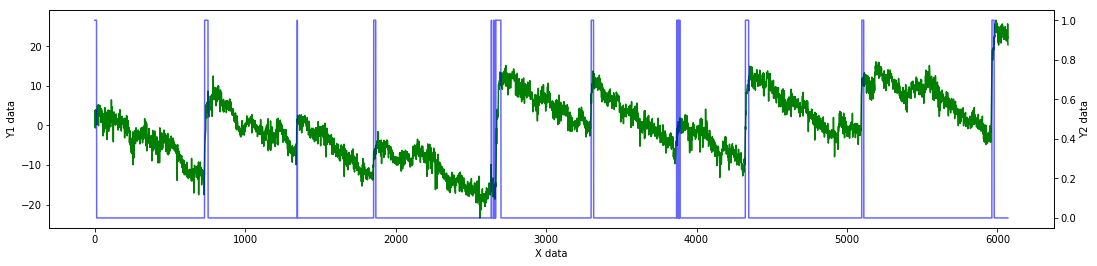

In [24]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df_result.index, df_result['x'], 'g-')
ax2.plot(df_result.index, df_result['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

# 40 days Window Time

In [25]:
# Temporalize the data
lookback = 40
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [26]:
# load model
model_40 = load_model("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_40days.h5")
# summarize model.
model_40.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [27]:
y_pred_40 = model_40.predict_classes(X_gisb)

In [28]:
df_xarray_40 = df['x'].iloc[40:]
df_result_40 = pd.DataFrame(data=[df_xarray_40.values,y_pred_40]).T
df_result_40.columns = ['x','Events']

[]

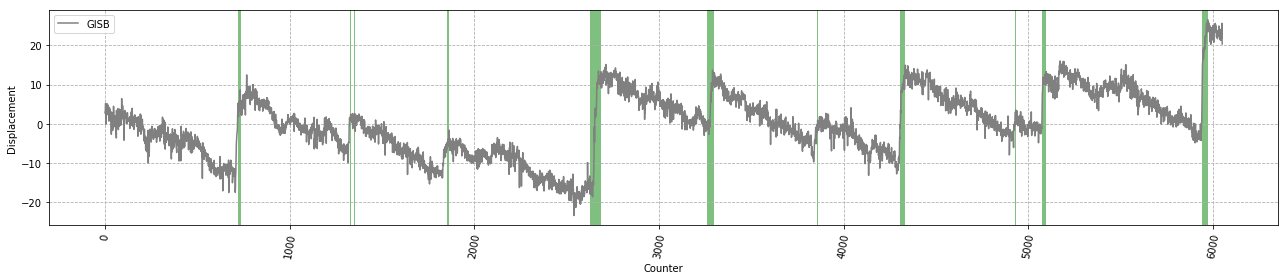

In [29]:
fig, ax = plt.subplots()

plt.plot(df_result_40['x'],'-', color='gray',label="GISB")

plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result_40['Events'])), min(df_result_40['Events']), max(df_result_40['Events']), 
                where=(df_result_40['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

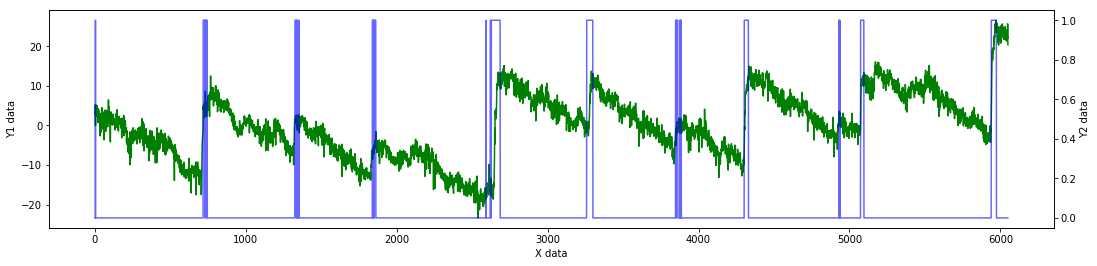

In [30]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df_result_40.index, df_result_40['x'], 'g-')
ax2.plot(df_result_40.index, df_result_40['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

# 5 days Window Time

In [31]:
# Temporalize the data
lookback = 5
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [32]:
# load model
model_5 = load_model("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_5days.h5")
# summarize model.
model_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [33]:
y_pred_5 = model_5.predict_classes(X_gisb)

In [34]:
df_xarray_5 = df['x'].iloc[5:]
df_result_5 = pd.DataFrame(data=[df_xarray_5.values,y_pred_5]).T
df_result_5.columns = ['x','Events']

[]

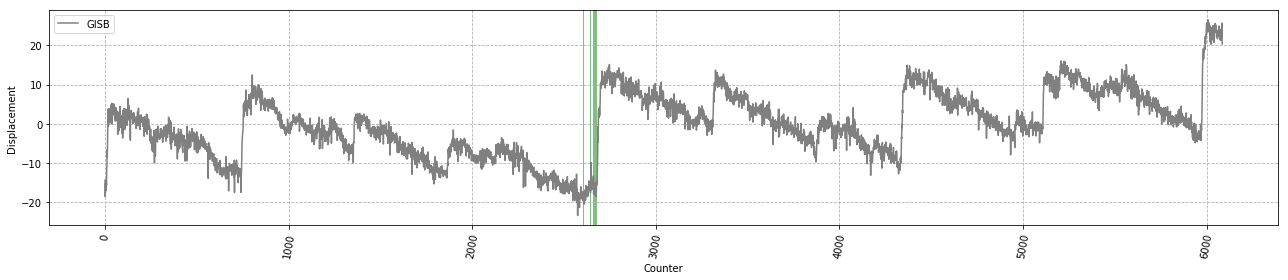

In [35]:
fig, ax = plt.subplots()

plt.plot(df_result_5['x'],'-', color='gray',label="GISB")

plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result_5['Events'])), min(df_result_5['Events']), max(df_result_5['Events']), 
                where=(df_result_5['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

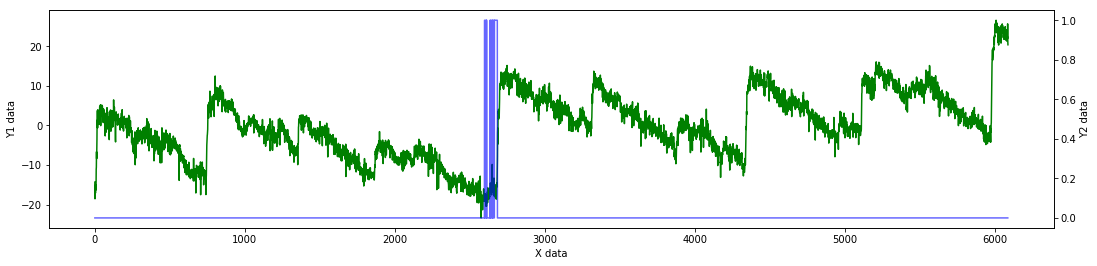

In [36]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df_result_5.index, df_result_5['x'], 'g-')
ax2.plot(df_result_5.index, df_result_5['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

# 60 days Time Window

In [37]:
# Temporalize the data
lookback = 60
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [38]:
# load model
model_60 = load_model("/home/francovm/Projects/SSE/models/Binary_clasifier/Binary_clasifier_LSTM_SSE_60days.h5")
# summarize model.
model_60.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [39]:
y_pred_60 = model_60.predict_classes(X_gisb)

In [40]:
df_xarray_60 = df['x'].iloc[5:]
df_result_60 = pd.DataFrame(data=[df_xarray_60.values,y_pred_60]).T
df_result_60.columns = ['x','Events']

[]

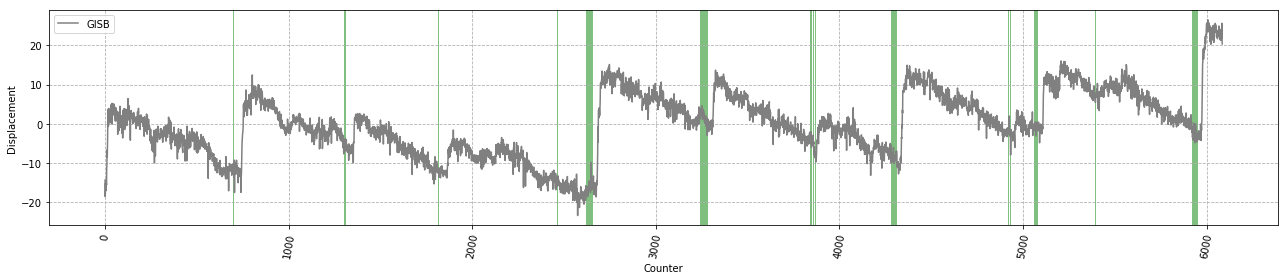

In [41]:
fig, ax = plt.subplots()

plt.plot(df_result_60['x'],'-', color='gray',label="GISB")

plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result_60['Events'])), min(df_result_60['Events']), max(df_result_60['Events']), 
                where=(df_result_60['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

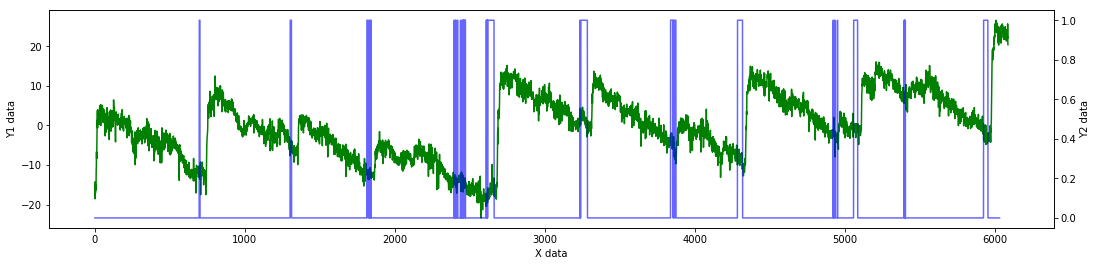

In [42]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df_result_60.index, df_result_60['x'], 'g-')
ax2.plot(df_result_60.index, df_result_60['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()